# Specific stellar angular momentum ($\lambda$ parameter)

From Toloba et al. 2015:

$\lambda_R = \dfrac{\Sigma^N_{i=1} F_i R_i |V_i|}{\Sigma^N_{i=1} F_i R_i \sqrt{V_i^2 + \sigma_i^2}}$

where $N$ is the number of spatial bins in the kinematic profiles, and $F_i, R_i, V_i$, and $\sigma_i$ are the flux, radius, rotation velocity, and velocity dispersion, respectively, of the $i$th bin


In [1]:
import pynbody
import numpy as np
import matplotlib.pyplot as plt
from luminosity import luminosity_plot

In [2]:
snap = "/home/michele/sim/MoRIA/M1-10_Verbeke2017/M10sim41001/snapshot_0036"
s = pynbody.load(snap)

In [3]:
pynbody.analysis.halo.center(s.s)

In [4]:
s.properties['boxsize'] = pynbody.units.Unit("1 Gpc")

In [5]:
# pynbody.plot.stars.render(s.s, width='8 kpc')

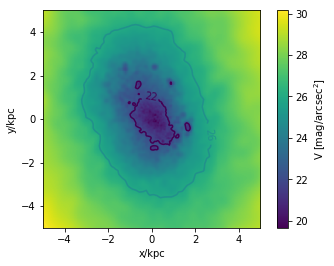

In [6]:
width = 10
resolution=500
fig, ax = plt.subplots()
img = surface_brightness(s, band='v', width=width, resolution=resolution, mag_filter=None, subplot=ax)
cont = ax.contour(img, cmap='viridis', levels=np.arange(18, 34, 4, dtype=np.int), extent=(-width/2, width/2, -width/2, width/2))
# ax_cont.set_aspect('equal')
plt.clabel(cont, inline=1, fmt='%1.0f');

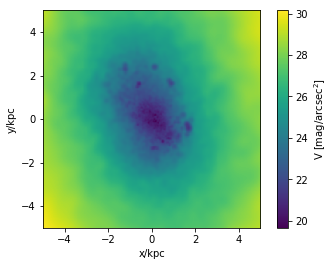

In [7]:
width = 10
resolution=500
fig, ax = plt.subplots()
img = surface_brightness(s, band='v', width=width, resolution=resolution, mag_filter=None, subplot=ax)
# cont = ax.contour(img, cmap='viridis', extent=(-width/2, width/2, -width/2, width/2))
# ax_cont.set_aspect('equal')
# plt.clabel(cont, inline=1, fmt='%1.0f');

In [8]:
from photutils import isophote, aperture_photometry
from photutils import CircularAperture, EllipticalAperture, EllipticalAnnulus
from photutils.isophote import EllipseGeometry, Ellipse

In [9]:
img[np.isnan(img)] = 0  # in case I used the `mag_filter` parameter

### Photometry

In [10]:
center = (resolution/2, resolution/2)

In [11]:
ell_aperture = EllipticalAperture(center, a=80, b=40, theta=120*np.pi/180)

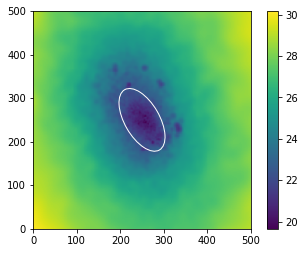

In [12]:
my_img = plt.imshow(img, origin='lower')
ell_aperture.plot(color='white')
plt.colorbar(my_img);

In [13]:
annulus = EllipticalAnnulus(center, a_in=80, a_out=100, b_out=40, theta=120*np.pi/180)

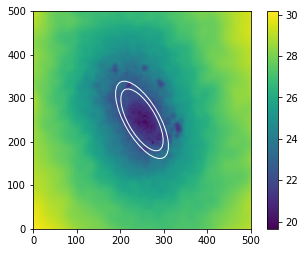

In [14]:
my_img = plt.imshow(img, origin='lower')
annulus.plot(color='white')
plt.colorbar(my_img);

In [15]:
annulus_table = aperture_photometry(img, annulus)
annulus_table

id,xcenter,ycenter,aperture_sum
,pix,pix,
int64,float64,float64,float64
1,250.0,250.0,101609.21142744782


## First approach
Use directly the semimajor axis

In [16]:
# eccentricity = 0.5
# a_delta = 20
# theta = 120*np.pi/180
# a = np.arange(20, 200, a_delta)
# print(a)
# b = a * np.sqrt(1 - eccentricity**2)
# apertures = [EllipticalAnnulus(center, a_in=a_i, a_out=a_i+a_delta, b_out=b_i, theta=theta) for a_i, b_i in zip(a, b)]
# phot_table = aperture_photometry(img, apertures)
# for col in phot_table.colnames:
#     phot_table[col].info.format = '%.8g'  # for consistent table output
# print(phot_table)

In [17]:
# my_img = plt.imshow(img, origin='lower')
# for ann in apertures:
#     ann.plot(color='white')
# plt.colorbar(my_img);

## Second approach
Decide a radius along the semimajor axis (analogous to the "slit")

In [18]:
from astropy import units as u

In [19]:
q = u.Quantity(img, unit=u.mag/u.arcsec**2)
q

<Quantity [[30.155396, 30.141869, 30.128506, ..., 29.051071, 29.06525 ,
            29.079618],
           [30.146626, 30.13281 , 30.119171, ..., 29.0395  , 29.053738,
            29.068163],
           [30.137924, 30.123829, 30.109917, ..., 29.028053, 29.042343,
            29.056826],
           ...,
           [29.208544, 29.18177 , 29.155643, ..., 29.500706, 29.516222,
            29.531963],
           [29.21692 , 29.190033, 29.163795, ..., 29.506088, 29.52173 ,
            29.537603],
           [29.225365, 29.198359, 29.172009, ..., 29.511494, 29.527267,
            29.543276]] mag / arcsec2>

In [21]:
eccentricity = 0.5
a_delta = 20
theta = 120*np.pi/180

radii = np.arange(30, 200, a_delta)
print(radii)

b = radii * np.sqrt(1 - eccentricity**2)
apertures = [EllipticalAnnulus(center, a_in=r-a_delta, a_out=r+a_delta, b_out=b_i, theta=theta) for r, b_i in zip(radii, b)]
flux_table = aperture_photometry(q, apertures)
for col in phot_table.colnames:
    flux_table[col].info.format = '%.8g'  # for consistent table output
print(flux_table)

[ 30  50  70  90 110 130 150 170 190]
 id xcenter ycenter ... aperture_sum_6 aperture_sum_7 aperture_sum_8
      pix     pix   ... mag / arcsec2  mag / arcsec2  mag / arcsec2 
--- ------- ------- ... -------------- -------------- --------------
  1     250     250 ...      726256.36      851065.49      978554.04


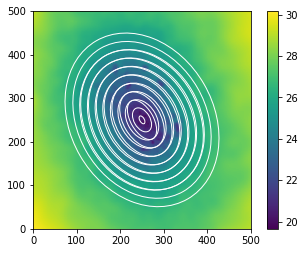

In [19]:
my_img = plt.imshow(img, origin='lower')
for ann in apertures:
    ann.plot(color='white')
plt.colorbar(my_img);

In [23]:
phot_table.meta

OrderedDict([('name', 'Aperture photometry results'),
             ('version', 'astropy: 3.0.4, photutils: 0.5'),
             ('aperture_photometry_args', "method='exact', subpixels=5")])

### Fit ellipse and find isophotal

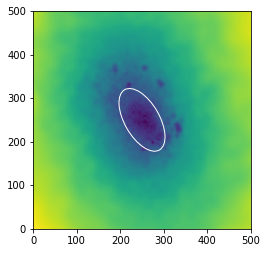

In [10]:
init_geometry = EllipseGeometry(x0=resolution/2, y0=resolution/2, sma=80, eps=0.5, pa=120.*np.pi/180.)

aper = EllipticalAperture((init_geometry.x0, init_geometry.y0), init_geometry.sma,
                           init_geometry.sma*(1 - init_geometry.eps),
                           init_geometry.pa)
plt.imshow(img, origin='lower')
aper.plot(color='white')

In [11]:
ellipse = Ellipse(img, init_geometry)
ellipse

In [12]:
isolist = ellipse.fit_image()

In [60]:
isolist.pa

array([0.        , 2.0943951 , 2.0943951 , 2.0943951 , 2.0943951 ,
       2.0943951 , 2.0943951 , 2.0943951 , 2.0943951 , 2.0943951 ,
       2.0943951 , 2.0943951 , 2.0943951 , 2.0943951 , 2.0943951 ,
       2.0943951 , 2.0943951 , 2.0943951 , 2.0943951 , 2.0943951 ,
       2.0943951 , 2.0943951 , 2.0943951 , 2.0943951 , 2.0943951 ,
       2.0943951 , 1.80111426, 1.90827041, 2.0943951 , 2.0943951 ,
       2.0943951 , 2.0943951 , 2.0943951 , 2.0943951 , 2.0943951 ,
       2.0943951 , 2.0943951 , 2.0943951 , 2.0943951 , 2.0943951 ,
       2.0943951 , 2.0943951 , 2.0943951 , 2.0943951 , 2.0943951 ,
       2.0943951 , 2.0943951 , 2.0943951 , 0.74984114, 0.74984114,
       2.32063747, 2.32063747, 2.32063747, 2.11679564, 2.0943951 ,
       1.9964556 , 2.11261617, 2.06976399, 2.06976399, 2.21239377,
       2.21239377, 2.21239377])

In [61]:
# isolist.to_table()

Text(0,0.5,'y0')

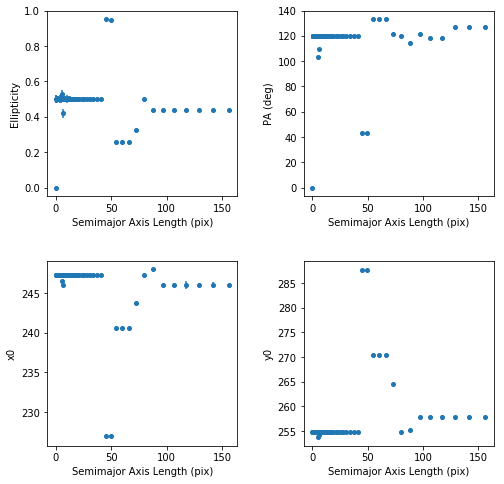

In [62]:
plt.figure(figsize=(8, 8))
plt.subplots_adjust(hspace=0.35, wspace=0.35)

plt.subplot(2, 2, 1)
plt.errorbar(isolist.sma, isolist.eps, yerr=isolist.ellip_err,
             fmt='o', markersize=4)
plt.xlabel('Semimajor Axis Length (pix)')
plt.ylabel('Ellipticity')

plt.subplot(2, 2, 2)
plt.errorbar(isolist.sma, isolist.pa/np.pi*180.,
             yerr=isolist.pa_err/np.pi* 80., fmt='o', markersize=4)
plt.xlabel('Semimajor Axis Length (pix)')
plt.ylabel('PA (deg)')

plt.subplot(2, 2, 3)
plt.errorbar(isolist.sma, isolist.x0, yerr=isolist.x0_err, fmt='o',
             markersize=4)
plt.xlabel('Semimajor Axis Length (pix)')
plt.ylabel('x0')

plt.subplot(2, 2, 4)
plt.errorbar(isolist.sma, isolist.y0, yerr=isolist.y0_err, fmt='o',
             markersize=4)
plt.xlabel('Semimajor Axis Length (pix)')
plt.ylabel('y0')

In [63]:
from photutils.isophote import build_ellipse_model
model_image = build_ellipse_model(img.shape, isolist)
residual = img - model_image

KeyboardInterrupt: 

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(figsize=(14, 5), nrows=1, ncols=3)
fig.subplots_adjust(left=0.04, right=0.98, bottom=0.02, top=0.98)
ax1.imshow(img, origin='lower')
ax1.set_title('Data')

smas = np.linspace(10, 50, 5)
for sma in smas:
    iso = isolist.get_closest(sma)
    x, y, = iso.sampled_coordinates()
    ax1.plot(x, y, color='white')

ax2.imshow(model_image, origin='lower')
ax2.set_title('Ellipse Model')

ax3.imshow(residual, origin='lower')
ax3.set_title('Residual')

# Sersic fit

In [ ]:
from astropy.modeling import models, fitting
resolution=500
# Fit the data using a box model
y, x = np.mgrid[:resolution, :resolution]

In [ ]:
s_init = models.Sersic2D(r_eff=50, n=2, x_0=resolution/2, y_0=resolution/2, ellip=0.7, theta=-np.pi/4,
                         fixed={'amplitude':False, 'n':False, 'ellip':False, 'x_0':True, 'y_0':True},
                         bounds={})#'theta':(0, np.pi)})
fit_s = fitting.SLSQPLSQFitter()
# notnans = np.isfinite(img)
# sersic = fit_s(s_init, x[notnans], y[notnans], img[notnans])
sersic = fit_s(s_init, x, y, img)
sersic

In [ ]:
# Plot the data with the best-fit model
plt.figure(figsize=(8,2.5))
plt.subplot(1,3,1)
plt.imshow(img, origin='lower', interpolation='nearest')
plt.title("Data")
plt.subplot(1,3,2)
plt.imshow(sersic(x, y), origin='lower', interpolation='nearest')
plt.title("Model")
plt.subplot(1,3,3)
plt.imshow(img - sersic(x, y), origin='lower', interpolation='nearest')
plt.title("Residual");

## Gaussian fitting

In [ ]:
# Fit the data using a Gaussian
g_init = models.Gaussian2D(amplitude=1., x_mean=resolution/2, y_mean=resolution/2, x_stddev=1,
                          bounds={'theta':(0, np.pi)})
fit_g = fitting.LevMarLSQFitter()
g = fit_g(g_init, x, y, img)
g

In [ ]:
# plt.imshow(np.log(img), origin='lower')
# plt.colorbar()

In [ ]:
# Plot the data with the best-fit model
plt.figure(figsize=(8,2.5))
plt.subplot(1,3,1)
img_orig = img.copy()
img_orig[img_orig==0]=np.nan
plt.imshow(img_orig, origin='lower', interpolation='nearest')
# cmap=plt.get_cmap()
# cmap.set_bad('k')
plt.title("Data")
plt.subplot(1,3,2)
plt.imshow(g(x, y), origin='lower', interpolation='nearest')
plt.title("Model")
plt.subplot(1,3,3)
plt.imshow(img - g(x, y), origin='lower', interpolation='nearest')
plt.title("Residual");

## Ellipse fitting

In [ ]:
e_init = models.Ellipse2D(amplitude=22, x_0=resolution/2, y_0=resolution/2, a=100, b=50, theta=-np.pi/4,
                          fixed={'amplitude':True, 'x_0':True, 'y_0':True, 'a':True, 'b':True},
                          bounds={'a':(0, 5*resolution), 'b':(0, 5*resolution)})
fit_e = fitting.SLSQPLSQFitter()
e = fit_e(e_init, x, y, img)
e

In [ ]:
# Plot the data with the best-fit model
plt.figure(figsize=(8,2.5))
plt.subplot(1,3,1)
plt.imshow(img, origin='lower', interpolation='nearest')
plt.title("Data")
plt.subplot(1,3,2)
plt.imshow(e(x, y), origin='lower', interpolation='nearest')
plt.title("Model")
plt.subplot(1,3,3)
plt.imshow(img - e(x, y), origin='lower', interpolation='nearest')
plt.title("Residual");

In [ ]:
pynbody.plot.density_profile(s, fit=True, fit_factor=0.5)

In [ ]:
pynbody.plot.stars.sbprofile(s, fit_sersic=True, rmax=10, diskheight=100)